In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
from torchvision.transforms import functional as F
from torchvision import transforms
from cnn_finetune import make_model

import model as M
from data import *
from util import *

In [3]:
torch.cuda.is_available()

True

# Show dataset

In [4]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
depth_df = pd.read_csv(depth_csv)

train_df = pd.merge(train_df, depth_df, on='id')
test_df = pd.merge(test_df, depth_df, on='id')

## rle_mask NaN case

In [5]:
train_df.iloc[0]

id          575d24d81d
rle_mask           NaN
z                  843
Name: 0, dtype: object

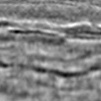

In [6]:
get_train_image(train_df.iloc[0]['id'])

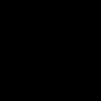

In [7]:
get_train_mask(train_df.iloc[0]['id'])

## rle_mask exists case

In [8]:
train_df.iloc[2]

id                                                 75efad62c1
rle_mask    9 93 109 94 210 94 310 95 411 95 511 96 612 96...
z                                                         468
Name: 2, dtype: object

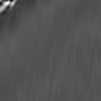

In [9]:
get_train_image(train_df.iloc[2]['id'])

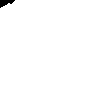

In [10]:
get_train_mask(train_df.iloc[2]['id'])

# Test rle_encoding method

In [5]:
transformer = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [6]:
mask_im = get_train_mask(train_df.iloc[3]['id'])
mask_im = transformer(mask_im)
mask_im = mask_im > 0.5
mask_im

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [42]:
im1 = get_train_image(train_df.iloc[3]['id'])
im2 = get_train_image(train_df.iloc[4]['id'])

im1 = transformer(im1)
im2 = transformer(im2)

im = torch.cat([im1, im2]).reshape(2, 1, 128, 128)

to_pil = transforms.ToPILImage()
resize = transforms.Resize((101, 101))

np.array([np.array(resize(to_pil(_))) for _ in im]).reshape(2, 1, 101, 101)

array([[[[134, 119, 101, ..., 155, 158, 162],
         [131, 114,  94, ..., 154, 157, 162],
         [127, 108,  86, ..., 151, 156, 163],
         ...,
         [107, 111, 114, ..., 159, 171, 178],
         [110, 113, 116, ..., 156, 163, 164],
         [113, 116, 118, ..., 153, 154, 150]]],


       [[[ 19,  21,  24, ...,  89,  80,  73],
         [ 29,  29,  28, ...,  81,  73,  67],
         [ 48,  45,  43, ...,  74,  68,  64],
         ...,
         [146, 149, 152, ..., 166, 168, 170],
         [177, 179, 182, ..., 169, 171, 173],
         [204, 206, 208, ..., 173, 176, 178]]]], dtype=uint8)

In [91]:
rle_encode(mask_im.numpy()) == RLenc(mask_im.numpy())

True

In [92]:
%%timeit
rle_encode(mask_im.numpy())

117 µs ± 994 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [93]:
%%timeit
RLenc(mask_im.numpy())

20.8 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Check model

In [94]:
model = M.UNet(1, 2)

In [95]:
im = get_train_image(train_df.iloc[102]['id'])
im = transformer(im)
im = im.expand(1, *im.shape)
y = model(im)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [96]:
y.shape

torch.Size([1, 2, 128, 128])

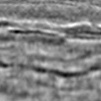

In [115]:
im = get_train_image(train_df.iloc[0]['id'])
im

In [122]:
(np.array(im.rotate(90)) == np.array(im)).all()

False

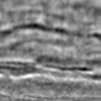

In [123]:
im.rotate(180)

In [9]:
x = np.random.rand(16, 1, 101, 101)
y = np.random.rand(16, 1, 101, 101)
z = np.empty((0, 1, 101, 101))

In [10]:
z = np.concatenate([z, x])

In [12]:
z = np.concatenate([z, y])

In [14]:
z.shape

(32, 1, 101, 101)